# System estimation

In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')

# importing local libararies
from src.systems.linear import StochasticDoubleIntegrator

from src.RL.PolicyGradient.SoftActorCritic_v2.PolicyFunction import SoftPolicyFunction
from src.RL.PolicyGradient.SoftActorCritic_v2.QFunction import SoftQFunction
from src.RL.PolicyGradient.SoftActorCritic_v2.main import SoftActorCritic


In [24]:
seed = 0
T = 40

key = jrandom.PRNGKey(seed)

# initiate system
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

lr_q, lr_pi = 1e-1, 1e-1
SAC = SoftActorCritic(2, 1, key)
SQF = SoftQFunction(3, key, eta=lr_q)
PI = SoftPolicyFunction(2, key, eta=lr_pi)

time_horizon = np.arange(0, T, SDI.dt)
keys = jrandom.split(key, 4)

s0_estimate = SDI.observe(key)
for t in time_horizon:
    control = np.random.normal()
    _, cost, done = SDI.update(keys[1], control, info=True)
    s1_estimate = SDI.observe(keys[2])

    state_transition = (s0_estimate, control, cost, s1_estimate)
    SAC.update(state_transition, keys[3], learning=False)

    # step
    s0_estimate = s1_estimate
    keys = jrandom.split(key, 4)

buffer = SAC.ReplayBuffer

In [122]:
key = jrandom.PRNGKey(0)
X = buffer.data_points[:buffer.size,:3]
t = buffer.data_points[:buffer.size,3:4]

class CostFunction:
    def __init__(self, key):
        self.order = 5
        self.params = jrandom.normal(key, (self.order+1,))

        self.regularization = False
    
    def generate_phi(self, X):
        N = len(X)
        phi = jnp.ones((N, 1))
        for pow in range(1, self.order+1):
            X_ext = X**pow
            phi = jnp.hstack([phi, X_ext])
        return phi

    def predict(self, X):
        phi = self.generate_phi(X)
        output = 0
        for x, w in zip(phi.T, self.params):
            output += jnp.dot(x, w)
        return output
    
    def optimize(self, X, t, sigma=.1, lamb=0):
        N, dim = X.shape
        D = dim * (self.order) + 1
        phi = self.generate_phi(X)
        self.params = jnp.linalg.pinv(jnp.dot(phi.T, phi) + D*lamb*jnp.identity(D)) @ jnp.dot(phi.T, t)
    
CF = CostFunction(key)
CF.optimize(X, t)

N = 10
x_space = np.linspace(-4, 4, N)
v_space = np.linspace(-4, 4, N)
u_space = np.linspace(-4, 4, N)
Y = np.zeros((10, 10, 10))
for i, x in enumerate(x_space):
    for j, v in enumerate(v_space):
        for k, u in enumerate(u_space):
            Y[i,j,k] = CF.predict(jnp.array([x, v, u], ndmin=2))




In [123]:
def func(x):
    A = jnp.array([1, 0, 1])
    B = jnp.array([0, 0, 0])
    c = 0
    return jnp.dot(x**2, A) + jnp.dot(x, B) + c

key = jrandom.PRNGKey(0)
keys = jrandom.split(key, 3)
x = jrandom.normal(keys[0], (20,1))*2
y = jrandom.normal(keys[1], (20,1))*4
z = jrandom.normal(keys[1], (20,1))*4
X = jnp.hstack([x, y, z])
t = func(X) + jrandom.normal(key, (20,))

CF = CostFunction(key)
CF.optimize(X, t)

for i, x in enumerate(x_space):
    for j, v in enumerate(v_space):
        for k, u in enumerate(u_space):
            Y[i,j,k] = CF.predict(jnp.array([x, v, u], ndmin=2))



Text(0.5, 0, 'z')

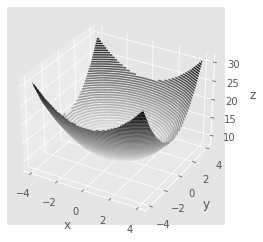

In [121]:
gridX, gridY = np.meshgrid(x_space, v_space)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(gridX, gridY, Y[:,0,:], 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [124]:
CF.params

DeviceArray([ 3.6164332e-05, -1.3564713e-05, -1.1158176e-05,
             -1.1166092e-05,  8.0101658e-05,  8.4887212e-04,
              8.4887212e-04, -1.2500025e-04, -4.9159676e-04,
             -4.9159676e-04,  7.3775649e-05,  2.1816477e-02,
              2.1816477e-02, -1.6735494e-03,  1.5234072e-03,
              1.5234072e-03], dtype=float32)